In [1]:
import numpy as np
import pandas as pd
import os

import sys



featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

sys.path

['c:\\Users\\linru\\Dropbox\\Columbia\\2022_fall\\deep_learning\\Research\\code\\deep-learning-wellington-od',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\python39.zip',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\DLLs',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\lib',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL',
 '',
 'C:\\Users\\linru\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\lib\\site-packages',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\lib\\site-packages\\win32',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\linru\\Anaconda3\\envs\\DL\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\linru\\AppData\\Roaming\\Python\\Python39\\site-packages\\IPython\\extensions',
 'C:\\Users\\linru\\.ipython']

In [2]:
def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape

(2503, 24)

In [40]:
!py -m pip install pyod

You should consider upgrading via the 'C:\Users\raymo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
import keras
import random
import numpy as np
from data_generation import gen_data
# from pyod.utils import pairwise_distances_no_broadcast
# from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction, OutlierMetric

In [4]:
# total_time = 30000
# seq_size = 25
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers = lstm_run(
    LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            64,
            64,
            128
        ], 
        mid_activation=tf.nn.tanh
    ),
    data_train_seq,
    data_test_seq,
    batch_size=512,
    epoch=300,
    metric="all",
    early_stopping=False
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")


Epoch 1/300
3/3 [==============================] - 5s 65ms/step - loss: 1.0156
Epoch 2/300
3/3 [==============================] - 0s 67ms/step - loss: 1.0145
Epoch 3/300
3/3 [==============================] - 0s 63ms/step - loss: 1.0130
Epoch 4/300
3/3 [==============================] - 0s 61ms/step - loss: 1.0103
Epoch 5/300
3/3 [==============================] - 0s 61ms/step - loss: 1.0061
Epoch 6/300
3/3 [==============================] - 0s 62ms/step - loss: 1.0008
Epoch 7/300
3/3 [==============================] - 0s 68ms/step - loss: 0.9967
Epoch 8/300
3/3 [==============================] - 0s 69ms/step - loss: 0.9932
Epoch 9/300
3/3 [==============================] - 0s 64ms/step - loss: 0.9886
Epoch 10/300
3/3 [==============================] - 0s 64ms/step - loss: 0.9835
Epoch 11/300
3/3 [==============================] - 0s 64ms/step - loss: 0.9786
Epoch 12/300
3/3 [==============================] - 0s 62ms/step - loss: 0.9730
Epoch 13/300
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 5ms/step
Data test shape (1002, 24)
lstm_pred shape (1002, 24)


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


ValueError: x and y must be the same size

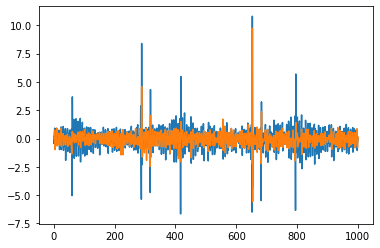

In [5]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt



plt.plot(range(len(data_test)), data_test[:,3], label = "original")
plt.plot(range(len(lstm_pred)), lstm_pred[:,3], label = "prediction")

for o in lstm_outliers:
    plt.scatter(np.linspace(-10,10,100), [o]*100)


In [101]:
pairwise_distances = np.square(data_test-lstm_pred)

metric = OutlierMetric()
indices = []
for i in range(24):
    indices.append(metric.quantile_outlier(l = pairwise_distances[:, i]))

lstm_pred.shape

(1002, 24)

In [22]:
from class_simulationhelper import SimulationHelpers 

sim = SimulationHelpers()
outliers = lstm_outliers["bb"]
sim.plot(
    # *lstm_pred.T[:len(companies)], 
    # *data_test.T[:6],
    *np.cumsum(data_test,axis = 1).T[:n_companies],
    outliers = [outliers for _ in range(n_companies)], 
    row_lim=4
)


NameError: name 'lstm_outliers' is not defined

In [23]:
sales = pd.read_csv("data/data4columbia_sales.csv")
date = featured_credit.iloc[partition_size].name
sales = sales.pivot_table(values="reported_sales", index="period_start_dt", columns="symbol")
sales = sales.loc[:,[col for col in companies if col in sales.columns]]

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime, timedelta
fig, ax = plt.subplots()
sales.loc[date:].fillna(method="ffill").diff().apply(lambda x: (x - x.mean())/x.std()).plot(figsize = [20,12], grid = True, ax = ax)
outliers = [(datetime.strptime(date, "%Y-%m-%d") + timedelta(days = d)).strftime("%Y-%m-%d") for d in lstm_outliers]
outliers = [outliers]
print(outliers)
for i, l in enumerate(outliers):
    cmap= iter(cm.rainbow(np.linspace(0, 1, len(l))))
    for point in l:
        ax.axvline(x = pd.Timestamp(point), color = next(cmap), linestyle = "--", alpha = 0.8)

FileNotFoundError: [Errno 2] No such file or directory: 'data/data4columbia_sales.csv'

In [7]:
pd.Timestamp("2022-10-01")

Timestamp('2022-10-01 00:00:00')

In [8]:

sales.loc[date:]

symbol,22328d65a8ae,695b1e497540,e2415cb7f63d,7cc4ff7756ca,8ded09ca1316,61bbe440bf3e,049fd91f3b99,8b8937c0ca2a
period_start_dt,,,,,,,,
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,3176.327,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-06-26,NaN,3270.804,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,NaN,2440.0,NaN,413.805,NaN,1604.0,NaN


In [1]:
from model_exec import OutlierMetric

metric = OutlierMetric()
x = [1,3,5,6,2,6,6,1,2,3,5,1,5,4, 17]
metric.iqr_outlier(x)

[14]